In [2]:
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib.ticker import FuncFormatter

import sys, os
sys.path.insert(0, os.path.dirname(os.getcwd()))
from metrics.calibration import *
plt.rcParams.update({
    "text.usetex": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # Optional: Include additional LaTeX packages as needed
    "font.family": "serif",  # You can specify a different font family if desired
})

In [14]:
def perturb_dist(confidences, smoothness, half_num_waves, scale):
  '''
  This function constructs a un-calibrated model by pertubating the conditional
  expectation E[Y|C] from C. The pertubation is composed of many waves scaled from
  zeta function defined below. The resulted conditional expectation E[Y|C=c] is
  s-Holder smooth with respect to c.

  Input:
    confidences: (C_1, ... , C_n) \in [0, 1]^n
    smoothness: Holder exponent s
    half_num_waves: m
    scale: \rho

  Output:
    The groundtruth condition expectation
    (E[Y|C_1], ... , E[Y|C_n]) where E[Y|C_i] = C_i+sign(C_i-0.5)*rho*m^(-s)*zeta(2*m*C_i)
  '''

  is_inner = (0.25 <= confidences) & (confidences <= 0.75)
  zeta = lambda x: np.exp(-1/x/(1 - x))
  rescale = lambda x: (2*half_num_waves*(x - 0.25)) % 1
  signs = lambda x: -(np.floor(2*half_num_waves*(x - 0.25)) % 2)*2+1
  perturbations = is_inner* scale * half_num_waves**(-smoothness) * zeta(rescale(confidences)) * signs(confidences)

  return confidences+perturbations

def real_rank_erce(p, smoothness, half_num_waves, scale):
  '''
  Output:
    The groundtruth l_p-Rank-ERCE(f)^p under the specific construction
    defined in perturb_dist.
  '''

  zeta = lambda x: np.exp(-p/x/(1 - x))
  res, _ = quad(zeta, 0, 1)
  return scale**p * half_num_waves**(-p*smoothness) * res/2

In [4]:
estimate_dict = {'PE-Rank': lambda u, a, B: rank_erce_est(u, a, B, 1),\
                 'PE-Rank2': lambda u, a, B: rank_erce_est(u, a, B, 2),\
                 'DPE-Rank2': lambda u, a, B: debias_rank_erce_est(u, a, B),\
                 'ADPE-Rank2': lambda u, a: adaptive_rank_erce_est(u, a)}

def evaluation_calibrated(n, B_list, num_trials, estimate_dict):

  res = {key: np.zeros((num_trials, len(B_list))) for key in estimate_dict.keys()}
  for idx_trial in range(num_trials):
    u = np.random.uniform(0.25, 0.75, size=n)
    fu = 2*u-0.5
    a = np.random.binomial(1, 1-fu, n) # discrete label

    for key, estimate in estimate_dict.items():
      if key != 'ADPE-Rank2':
        for idx_B, B in enumerate(B_list):
            res[key][idx_trial][idx_B] = estimate(u, a, B)
      else:
        res[key][idx_trial][idx_B] = estimate(u, a) if idx_B == 0 else res[key][idx_trial][0]
  return res

def evaluation_non_calibrated(n, B_list, s, m, rho, num_trials, estimate_dict):

  res = {key: np.zeros((num_trials, len(B_list))) for key in estimate_dict.keys()}
  for idx_trial in range(num_trials):
    u = np.random.uniform(0.25, 0.75, size=n)
    fu = 2*u-0.5
    perturbed_fu = perturb_dist(fu, s, m, rho)
    a = np.random.binomial(1, 1-perturbed_fu, n) # discrete label

    for idx_B, B in enumerate(B_list):
      for key, estimate in estimate_dict.items():
        if key != 'ADPE-Rank2':
            res[key][idx_trial][idx_B] = estimate(u, a, B)
        else:
          res[key][idx_trial][idx_B] = estimate(u, a) if idx_B == 0 else res[key][idx_trial][0]
  return res

# A synthetic perfectly calibrated toy model with $F(A)|F(U)\sim {\rm Bernoulli}(1-F(U))$.

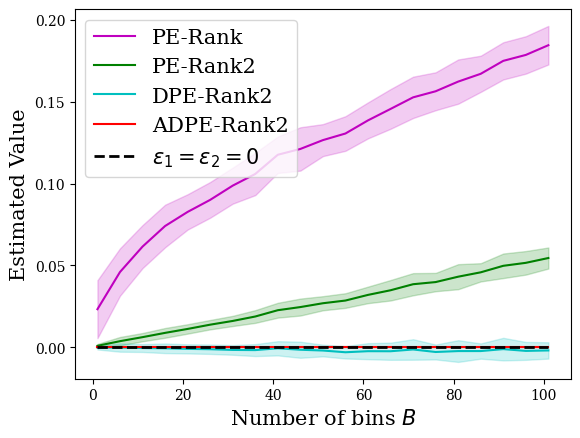

In [21]:
np.random.seed(2024) # reproducibility

n = 300
num_trials = 30

# perfect calibration, varying number of bins
B_list = range(1, 102, 5)
res = evaluation_calibrated(n, B_list, num_trials, estimate_dict)

plt.plot(B_list, res['PE-Rank'].mean(axis=0), label='PE-Rank', color='m')
plt.fill_between(B_list, res['PE-Rank'].mean(axis=0)-res['PE-Rank'].std(axis=0), res['PE-Rank'].mean(axis=0)+res['PE-Rank'].std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, res['PE-Rank2'].mean(axis=0), label='PE-Rank2', color='g')
plt.fill_between(B_list, res['PE-Rank2'].mean(axis=0)-res['PE-Rank2'].std(axis=0), res['PE-Rank2'].mean(axis=0)+res['PE-Rank2'].std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, res['DPE-Rank2'].mean(axis=0), label='DPE-Rank2', color='c')
plt.fill_between(B_list, res['DPE-Rank2'].mean(axis=0)-res['DPE-Rank2'].std(axis=0), res['DPE-Rank2'].mean(axis=0)+res['DPE-Rank2'].std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, res['ADPE-Rank2'].mean(axis=0), label='ADPE-Rank2', color='r')
plt.fill_between(B_list, res['ADPE-Rank2'].mean(axis=0)-res['ADPE-Rank2'].std(axis=0), res['ADPE-Rank2'].mean(axis=0)+res['ADPE-Rank2'].std(axis=0), color='r', alpha=0.2)

plt.plot(B_list, np.zeros_like(B_list), '--', label='$\epsilon_1=\epsilon_2=0$', color='black', linewidth=2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Estimated Value', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

# A synthetic poorly calibrated model with $F(A)|F(U)\sim {\rm Bernoulli}(1-F(U)-{\rm Perturb}(F(U)))$.

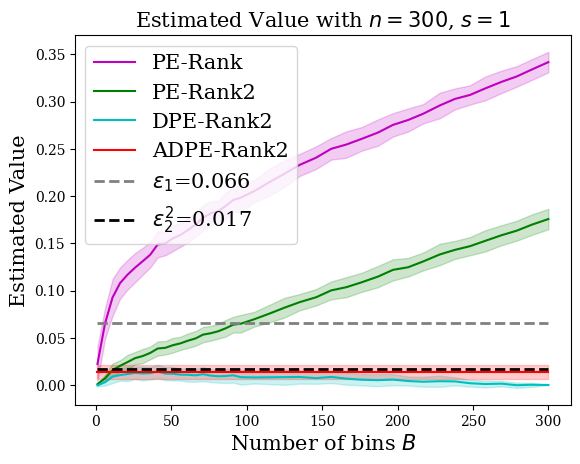

In [17]:
np.random.seed(2024) # reproducibility

n = 300
s = 1
m = int(n**(2 / (4*s + 1)))//2
rho =75
num_trials = 30

B_list = list(range(1, 101, 5))+list(np.linspace(105, n, 20).astype(int))
res = evaluation_non_calibrated(n, B_list, s, m, rho, num_trials, estimate_dict)

eps1, eps2_square = real_rank_erce(1, s, m, rho), real_rank_erce(2, s, m, rho)

plt.plot(B_list, res['PE-Rank'].mean(axis=0), label='PE-Rank', color='m')
plt.fill_between(B_list, res['PE-Rank'].mean(axis=0)-res['PE-Rank'].std(axis=0), res['PE-Rank'].mean(axis=0)+res['PE-Rank'].std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, res['PE-Rank2'].mean(axis=0), label='PE-Rank2', color='g')
plt.fill_between(B_list, res['PE-Rank2'].mean(axis=0)-res['PE-Rank2'].std(axis=0), res['PE-Rank2'].mean(axis=0)+res['PE-Rank2'].std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, res['DPE-Rank2'].mean(axis=0), label='DPE-Rank2', color='c')
plt.fill_between(B_list, res['DPE-Rank2'].mean(axis=0)-res['DPE-Rank2'].std(axis=0), res['DPE-Rank2'].mean(axis=0)+res['DPE-Rank2'].std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, res['ADPE-Rank2'].mean(axis=0), label='ADPE-Rank2', color='r')
plt.fill_between(B_list, res['ADPE-Rank2'].mean(axis=0)-res['ADPE-Rank2'].std(axis=0), res['ADPE-Rank2'].mean(axis=0)+res['ADPE-Rank2'].std(axis=0), color='r', alpha=0.2)

plt.plot(B_list, np.ones_like(B_list)*eps1,'--', label='$\epsilon_1$='+str(round(eps1, 3)), color='grey', linewidth=2)
plt.plot(B_list, np.ones_like(B_list)*eps2_square,'--', label='$\epsilon_2^2$='+str(round(eps2_square, 3)), color='black', linewidth=2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Estimated Value', fontsize=15)
plt.title(f'Estimated Value with $n={n}$, $s={s}$', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

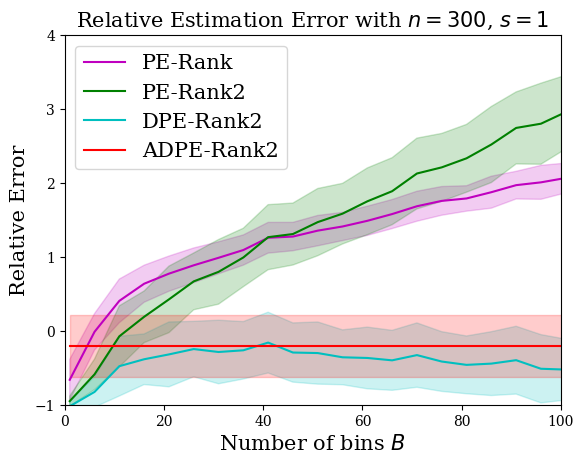

In [19]:
PE_rel = (res['PE-Rank']-eps1)/eps1
PE2_rel = (res['PE-Rank2']-eps2_square)/eps2_square
DPE_rel = (res['DPE-Rank2']-eps2_square)/eps2_square
ADPE_rel = (res['ADPE-Rank2']-eps2_square)/eps2_square

plt.plot(B_list, PE_rel.mean(axis=0), label='PE-Rank', color='m')
plt.fill_between(B_list, PE_rel.mean(axis=0)-PE_rel.std(axis=0), PE_rel.mean(axis=0)+PE_rel.std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, PE2_rel.mean(axis=0), label='PE-Rank2', color='g')
plt.fill_between(B_list, PE2_rel.mean(axis=0)-PE2_rel.std(axis=0), PE2_rel.mean(axis=0)+PE2_rel.std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, DPE_rel.mean(axis=0), label='DPE-Rank2', color='c')
plt.fill_between(B_list, DPE_rel.mean(axis=0)-DPE_rel.std(axis=0), DPE_rel.mean(axis=0)+DPE_rel.std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, np.ones_like(B_list)*ADPE_rel.mean(), label='ADPE-Rank2', color='r')
plt.fill_between(B_list, ADPE_rel.mean()-ADPE_rel.std(), ADPE_rel.mean()+ADPE_rel.std(), color='r', alpha=0.2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Relative Error', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.title(f'Relative Estimation Error with $n={n}$, $s={s}$', fontsize=15)
plt.ylim(-1, 4)
plt.xlim(0, 100)
plt.show()

/tmp/ipykernel_1013902/1340199803.py:20: RuntimeWarning: divide by zero encountered in divide
  zeta = lambda x: np.exp(-1/x/(1 - x))


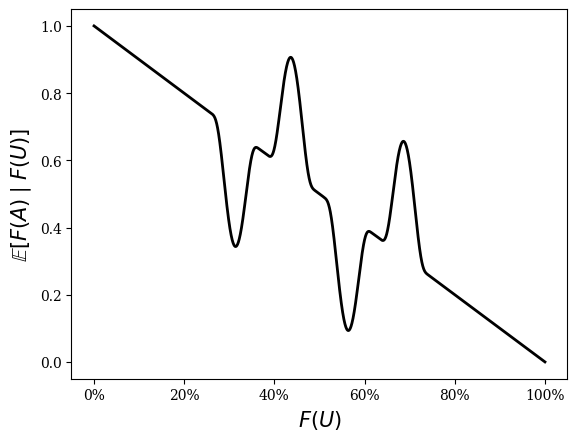

In [18]:
s = 1
m = int(n**(2 / (4*s + 1)))//2
rho = 75

u = np.linspace(0.25, 0.75, 3001)
fu = 2*u-0.5

plt.plot(fu, 1-perturb_dist(fu, s, m, rho), color='black', linewidth=2)
plt.xlabel('$F(U)$', fontsize=15)
plt.ylabel('$\mathbb{E}[F(A)\mid F(U)]$', fontsize=15)

def to_percent(x, position):
    return f"{int(x*100)}%"
formatter = FuncFormatter(to_percent)
plt.gca().xaxis.set_major_formatter(formatter)